In [1]:
library(dada2)
library(dplyr)

Loading required package: Rcpp


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
path = "~/scratch/reads/filterbytile/trimmed"

In [4]:
fnFs <- sort(list.files(path, pattern="_R1.fq.gz", full.names = TRUE))
fnRs <- sort(list.files(path, pattern="_R2.fq.gz", full.names = TRUE))
# Extract sample names, assuming filenames have format: SAMPLENAME_XXX.fastq
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)

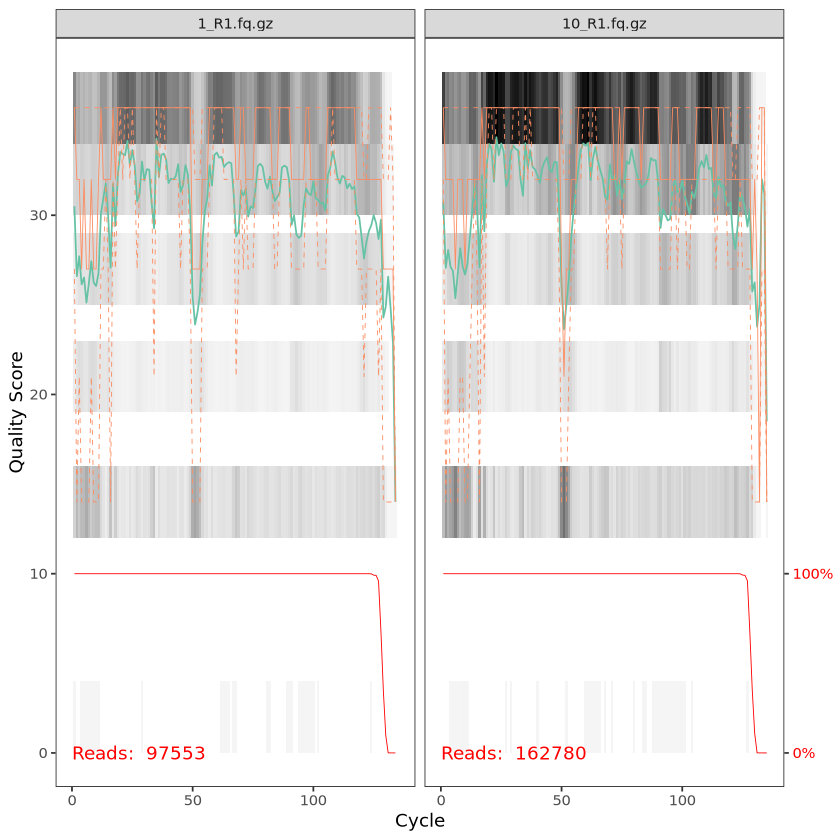

In [5]:
plotQualityProfile(fnFs[1:2])

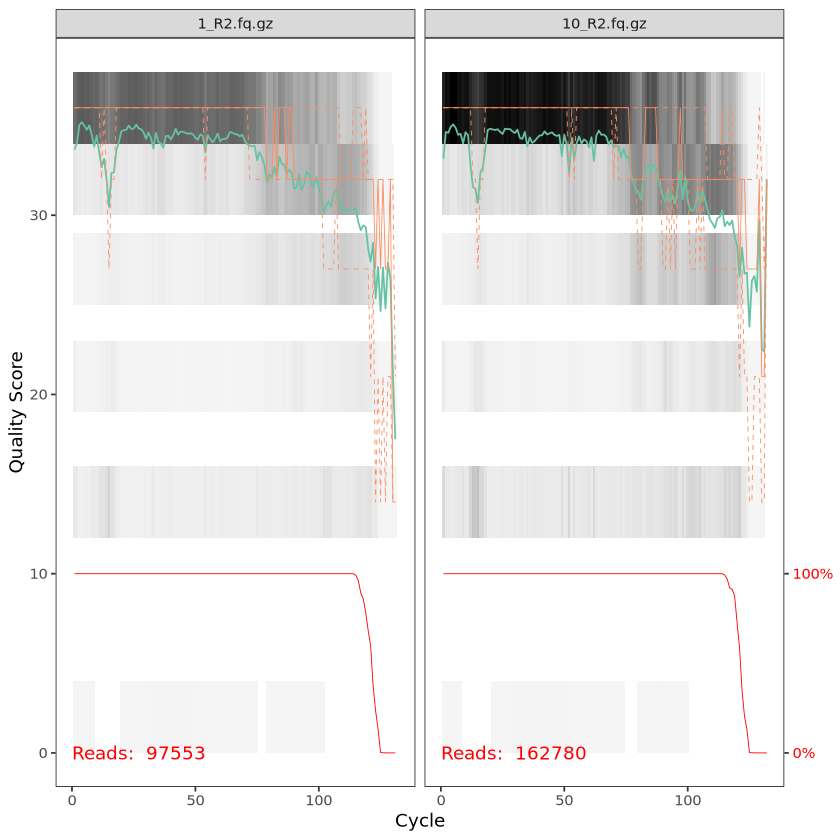

In [6]:
plotQualityProfile(fnRs[1:2])

In [7]:
filtFs <- file.path(path, "filtered", paste0(sample.names, "_F_filt.fastq.gz"))
filtRs <- file.path(path, "filtered", paste0(sample.names, "_R_filt.fastq.gz"))
names(filtFs) <- sample.names
names(filtRs) <- sample.names

In [9]:
out <- filterAndTrim(fnFs, filtFs, fnRs, filtRs, 
                     truncLen=c(120,110),
              maxN=0, maxEE=c(2,2), rm.phix=TRUE,
              compress=TRUE, multithread=8)
head(out)

Creating output directory: /storage/home/nsl5160/scratch/reads/filterbytile/trimmed/filtered

Some input samples had no reads pass the filter.



,reads.in,reads.out
1_R1.fq.gz,97553,93564
10_R1.fq.gz,162780,156645
100_R1.fq.gz,244517,235600
101_R1.fq.gz,198223,188269
102_R1.fq.gz,71817,68983
103_R1.fq.gz,196721,189211


In [11]:
filtFs <- filtFs[file.exists(filtFs)]
filtRs <- filtRs[file.exists(filtRs)]

In [12]:
errF <- learnErrors(filtFs, multithread=8)
errR <- learnErrors(filtRs, multithread=8)

111872640 total bases in 932272 reads from 6 samples will be used for learning the error rates.
102549920 total bases in 932272 reads from 6 samples will be used for learning the error rates.


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


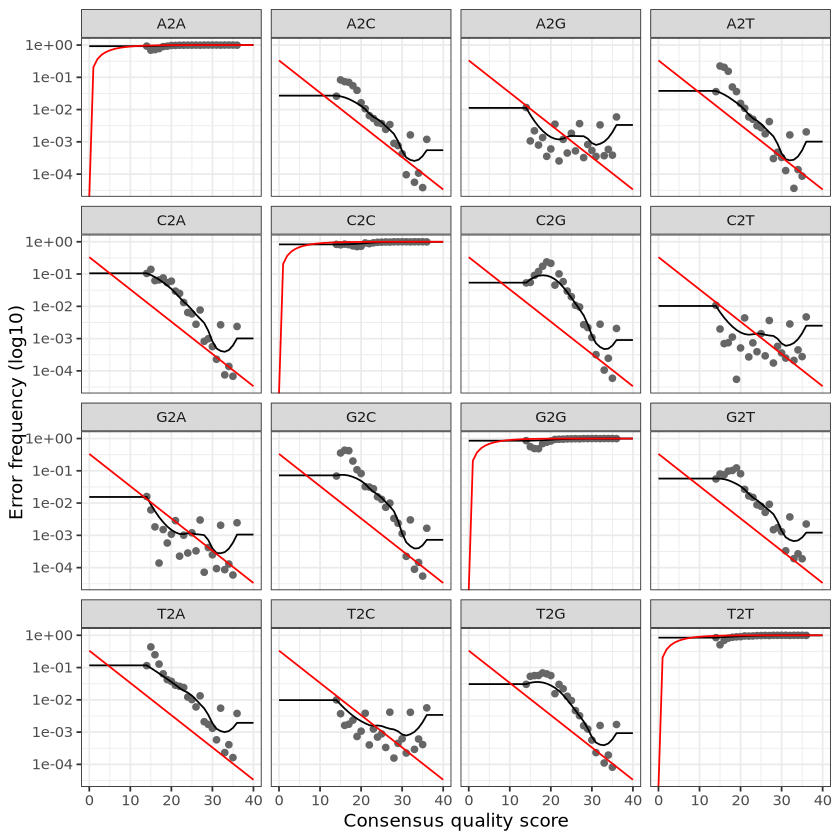

In [13]:
plotErrors(errF, nominalQ=TRUE)

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


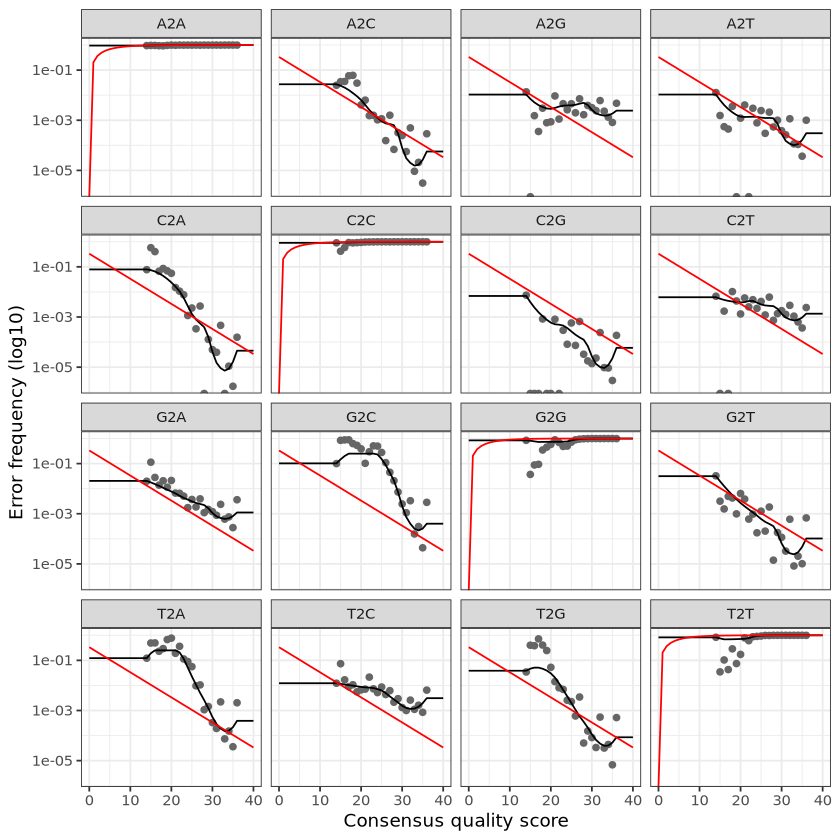

In [14]:
plotErrors(errR, nominalQ=TRUE)

In [15]:
errFbinadj <- learnErrors(filtFs, multithread=8, verbose = TRUE,
                          errorEstimationFunction = loessErrfun_mod4)
errRbinadj <- learnErrors(filtRs, multithread=8, verbose = TRUE,
                          errorEstimationFunction = loessErrfun_mod4)

111872640 total bases in 932272 reads from 6 samples will be used for learning the error rates.
Initializing error rates to maximum possible estimate.
selfConsist step 1 ......
   selfConsist step 2
   selfConsist step 3
   selfConsist step 4
   selfConsist step 5
   selfConsist step 6
   selfConsist step 7
   selfConsist step 8
   selfConsist step 9
   selfConsist step 10


Self-consistency loop terminated before convergence.



102549920 total bases in 932272 reads from 6 samples will be used for learning the error rates.
Initializing error rates to maximum possible estimate.
selfConsist step 1 ......
   selfConsist step 2
   selfConsist step 3
   selfConsist step 4
   selfConsist step 5
   selfConsist step 6
   selfConsist step 7
Convergence after  7  rounds.


It seems like the adjusted error model (Option 4 in https://github.com/benjjneb/dada2/issues/1307#issuecomment-957680971) that accomodates NextSeq binned Q scores does much better than the default model (e.g. look at the monotonicity) so we'll use this moving forward instead of the default error model. Given that the Q scores look fairly messed up from fastQC, I still suspect that we have an issue with not enough sequence diversity in the run, so my recommendation is a greater PhiX spike in the future.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


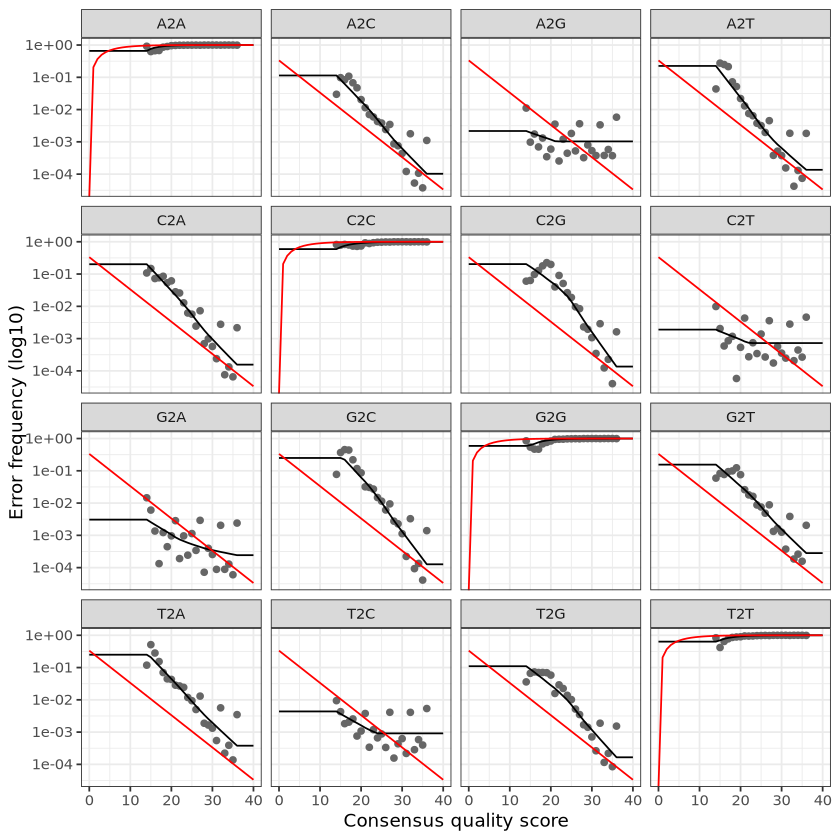

In [16]:
plotErrors(errFbinadj, nominalQ=TRUE)

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


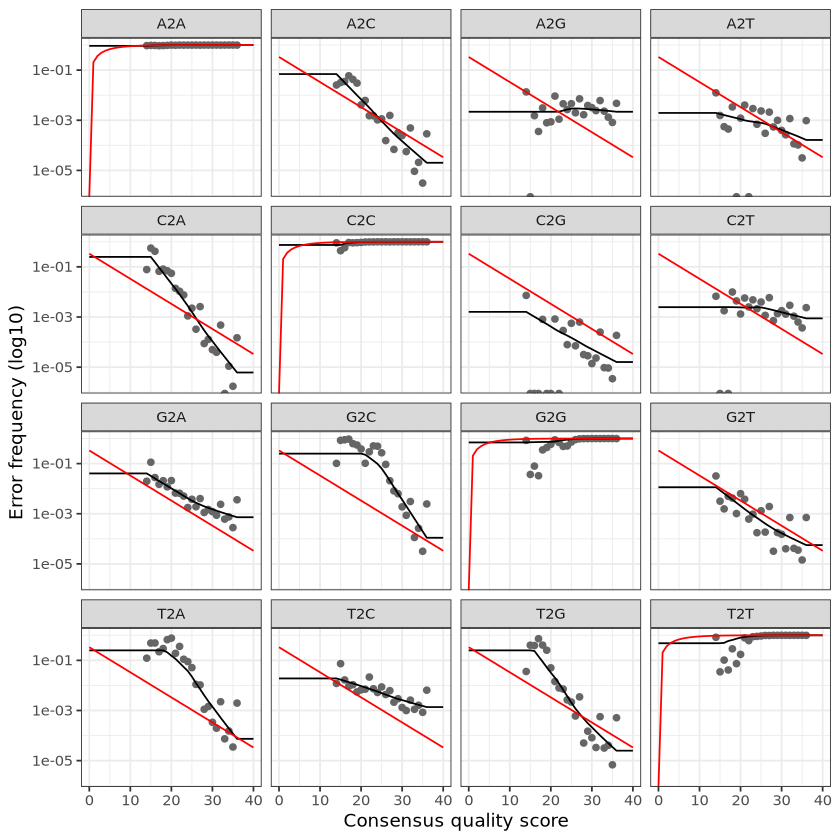

In [17]:
plotErrors(errRbinadj, nominalQ=TRUE)

In [18]:
dadaFs <- dada(filtFs, err=errFbinadj, multithread=8)

Sample 1 - 93564 reads in 45790 unique sequences.
Sample 2 - 156645 reads in 68016 unique sequences.
Sample 3 - 235600 reads in 100143 unique sequences.
Sample 4 - 188269 reads in 99924 unique sequences.
Sample 5 - 68983 reads in 37404 unique sequences.
Sample 6 - 189211 reads in 84772 unique sequences.
Sample 7 - 50 reads in 50 unique sequences.
Sample 8 - 179221 reads in 66882 unique sequences.
Sample 9 - 38 reads in 38 unique sequences.
Sample 10 - 240175 reads in 82352 unique sequences.
Sample 11 - 67897 reads in 32064 unique sequences.
Sample 12 - 223921 reads in 69520 unique sequences.
Sample 13 - 155807 reads in 72743 unique sequences.
Sample 14 - 200966 reads in 53217 unique sequences.
Sample 15 - 244868 reads in 74407 unique sequences.
Sample 16 - 208480 reads in 62085 unique sequences.
Sample 17 - 249672 reads in 77828 unique sequences.
Sample 18 - 127899 reads in 48574 unique sequences.
Sample 19 - 290128 reads in 86929 unique sequences.
Sample 20 - 239327 reads in 65620 uni

In [19]:
dadaRs <- dada(filtRs, err=errRbinadj, multithread=8)

Sample 1 - 93564 reads in 17277 unique sequences.
Sample 2 - 156645 reads in 25291 unique sequences.
Sample 3 - 235600 reads in 46260 unique sequences.
Sample 4 - 188269 reads in 27443 unique sequences.
Sample 5 - 68983 reads in 14590 unique sequences.
Sample 6 - 189211 reads in 28543 unique sequences.
Sample 7 - 50 reads in 47 unique sequences.
Sample 8 - 179221 reads in 24778 unique sequences.
Sample 9 - 38 reads in 34 unique sequences.
Sample 10 - 240175 reads in 31388 unique sequences.
Sample 11 - 67897 reads in 8902 unique sequences.
Sample 12 - 223921 reads in 33400 unique sequences.
Sample 13 - 155807 reads in 29716 unique sequences.
Sample 14 - 200966 reads in 26747 unique sequences.
Sample 15 - 244868 reads in 36081 unique sequences.
Sample 16 - 208480 reads in 27150 unique sequences.
Sample 17 - 249672 reads in 34460 unique sequences.
Sample 18 - 127899 reads in 22835 unique sequences.
Sample 19 - 290128 reads in 40565 unique sequences.
Sample 20 - 239327 reads in 31758 uniqu

In [20]:
mergers <- mergePairs(dadaFs, filtFs, dadaRs, filtRs, verbose=TRUE)
head(mergers[[1]])

88225 paired-reads (in 475 unique pairings) successfully merged out of 92754 (in 1094 pairings) input.

152486 paired-reads (in 850 unique pairings) successfully merged out of 155346 (in 1328 pairings) input.

226964 paired-reads (in 1863 unique pairings) successfully merged out of 232706 (in 3353 pairings) input.

165936 paired-reads (in 760 unique pairings) successfully merged out of 186478 (in 975 pairings) input.

66952 paired-reads (in 393 unique pairings) successfully merged out of 68219 (in 674 pairings) input.

183028 paired-reads (in 1640 unique pairings) successfully merged out of 187030 (in 2908 pairings) input.

9 paired-reads (in 1 unique pairings) successfully merged out of 9 (in 1 pairings) input.

177310 paired-reads (in 1282 unique pairings) successfully merged out of 177996 (in 1510 pairings) input.

18 paired-reads (in 1 unique pairings) successfully merged out of 18 (in 1 pairings) input.

237712 paired-reads (in 1989 unique pairings) successfully merged out of 2379

97606 paired-reads (in 622 unique pairings) successfully merged out of 116291 (in 1228 pairings) input.

230658 paired-reads (in 1532 unique pairings) successfully merged out of 234657 (in 1842 pairings) input.

273592 paired-reads (in 2223 unique pairings) successfully merged out of 279432 (in 2769 pairings) input.

265354 paired-reads (in 1943 unique pairings) successfully merged out of 272217 (in 2496 pairings) input.

No paired-reads (in ZERO unique pairings) successfully merged out of 87 pairings) input.

286027 paired-reads (in 1955 unique pairings) successfully merged out of 293208 (in 3399 pairings) input.

262793 paired-reads (in 1184 unique pairings) successfully merged out of 273766 (in 2325 pairings) input.

249690 paired-reads (in 1535 unique pairings) successfully merged out of 252439 (in 1909 pairings) input.

242824 paired-reads (in 1636 unique pairings) successfully merged out of 242937 (in 1709 pairings) input.

281327 paired-reads (in 1447 unique pairings) successful

No paired-reads (in ZERO unique pairings) successfully merged out of 26 pairings) input.

No paired-reads (in ZERO unique pairings) successfully merged out of 33 pairings) input.

13 paired-reads (in 1 unique pairings) successfully merged out of 13 (in 1 pairings) input.

239467 paired-reads (in 2131 unique pairings) successfully merged out of 245063 (in 3698 pairings) input.

No paired-reads (in ZERO unique pairings) successfully merged out of 12 pairings) input.

196175 paired-reads (in 1620 unique pairings) successfully merged out of 203586 (in 3074 pairings) input.

251227 paired-reads (in 2263 unique pairings) successfully merged out of 259391 (in 3659 pairings) input.

265374 paired-reads (in 2139 unique pairings) successfully merged out of 273965 (in 3601 pairings) input.

256644 paired-reads (in 1992 unique pairings) successfully merged out of 266251 (in 3675 pairings) input.

233497 paired-reads (in 1441 unique pairings) successfully merged out of 242916 (in 2582 pairings) inp

220472 paired-reads (in 1360 unique pairings) successfully merged out of 222333 (in 2008 pairings) input.

1 paired-reads (in 1 unique pairings) successfully merged out of 1 (in 1 pairings) input.

111267 paired-reads (in 509 unique pairings) successfully merged out of 111267 (in 509 pairings) input.

87014 paired-reads (in 528 unique pairings) successfully merged out of 87014 (in 528 pairings) input.

109664 paired-reads (in 782 unique pairings) successfully merged out of 111122 (in 912 pairings) input.

151506 paired-reads (in 1082 unique pairings) successfully merged out of 157442 (in 1952 pairings) input.

107146 paired-reads (in 521 unique pairings) successfully merged out of 110475 (in 953 pairings) input.

60349 paired-reads (in 386 unique pairings) successfully merged out of 60996 (in 559 pairings) input.

53128 paired-reads (in 241 unique pairings) successfully merged out of 56477 (in 532 pairings) input.

231565 paired-reads (in 1392 unique pairings) successfully merged out o

143321 paired-reads (in 521 unique pairings) successfully merged out of 154944 (in 1247 pairings) input.

12373 paired-reads (in 72 unique pairings) successfully merged out of 12841 (in 138 pairings) input.

195521 paired-reads (in 1386 unique pairings) successfully merged out of 204052 (in 2255 pairings) input.

0 paired-reads (in 0 unique pairings) successfully merged out of 1 (in 1 pairings) input.

188222 paired-reads (in 893 unique pairings) successfully merged out of 195038 (in 1609 pairings) input.

146879 paired-reads (in 768 unique pairings) successfully merged out of 154046 (in 1532 pairings) input.

128702 paired-reads (in 682 unique pairings) successfully merged out of 131917 (in 1133 pairings) input.

126537 paired-reads (in 774 unique pairings) successfully merged out of 139173 (in 1826 pairings) input.

75152 paired-reads (in 360 unique pairings) successfully merged out of 80497 (in 822 pairings) input.

129840 paired-reads (in 742 unique pairings) successfully merged ou

,sequence,abundance,forward,reverse,nmatch,nmismatch,nindel,prefer,accept
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<lgl>
1,GTCAGAGCTGCTACGAGAGGCCCAAGTTGACAAACCCCGGCGTAAAGAGACGTTAAGAAAAATTTAAAACTAAAGCCGAATGCCCTCAAAGCTGTTATACGCACCCGAAGGTAAGAAGCCCAATCACGAAAGTGGCTTTACATTTCCCGAACCCACGAAAGCTATGAAA,4432,1,1,61,0,0,2,TRUE
2,CACAGAGCTTATACGAGAGGCCCAAGTTGACAAACCCCGGCGTAAAGAGACGTTAAGAAAAATTTAAAACTAAAGCCGAATGCCCTCAAAGCTGTTATACGCACCCGAAGGTAAGAAGCCCAATCACGAAAGTGGCTTTACATTTCCCGAACCCACGAAAGCTATGAAA,2064,2,1,61,0,0,2,TRUE
3,CTGCTATGATAGACGAGAGGCCCAAGTTGACAAACCCCGGCGTAAAGAGTCCTTAAGAAAAATTTAAAACTAAAGCCGAATGCCCTCAAAGCTGTTATACGCACCCGAAGGTAAGAAGCCCAATCACGAAAGTGGCTTTACATTTCCCGAACCCACGAAAGCTATGAAA,1702,4,1,61,0,0,2,TRUE
4,GACATCGGGGATACGAGAGGCCCAAGTTGACAAACCCCGGCGTAAAGACAGGTTAAGAAAAATTTAAAACTAAAGCCGAATGCCCTCAAAGCTGTTATACGCACCCGAAGGTAAGAAGCCCAATCACGAAAGTGGCTTTACATTTCCCGAACCCACGAAAGCTATGAAA,1662,5,1,61,0,0,2,TRUE
5,CTGCGATGATAGACGAGAGGCCCAAGTTGACAAACCCCGGCGTAAAGAGTCCTTAAGAAAAATTTAAAACTAAAGCCGAATGCCCTCAAAGCTGTTATACGCACCCGAAGGTAAGAAGCCCAATCACGAAAGTGGCTTTACATTTCCCGAACCCACGAAAGCTATGAAA,1530,24,1,61,0,0,2,TRUE
6,CTCAGAGCTTATACGAGAGGCCCAAGTTGACAAACCCCGGCGTAAAGAGACGTTAAGAAAAATTTAAAACTAAAGCCGAATGCCCTCAAAGCTGTTATACGCACCCGAAGGTAAGAAGCCCAATCACGAAAGTGGCTTTACATTTCCCGAACCCACGAAAGCTATGAAA,1318,79,1,61,0,0,2,TRUE


In [21]:
seqtab <- makeSequenceTable(mergers)
dim(seqtab)

[1]    389 121318

In [22]:
seqtab.nochim <- removeBimeraDenovo(seqtab, method="consensus", 
                                    multithread=8, verbose=TRUE)
dim(seqtab.nochim)

Identified 113650 bimeras out of 121318 input sequences.



[1]  389 7668

In [23]:
sum(seqtab.nochim)/sum(seqtab)

[1] 0.7447933

In [24]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, getN), rowSums(seqtab.nochim))
# If processing a single sample, remove the sapply calls: e.g. replace sapply(dadaFs, getN) with getN(dadaFs)
colnames(track) <- c("input", "filtered", "denoisedF", "denoisedR", "merged", "nonchim")
rownames(track) <- sample.names
head(track)

Warning message in cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, :
“number of rows of result is not a multiple of vector length (arg 2)”


,input,filtered,denoisedF,denoisedR,merged,nonchim
1,97553,93564,92862,93445,88225,69819
10,162780,156645,155480,156488,152486,103839
100,244517,235600,233168,235115,226964,187818
101,198223,188269,186611,188100,165936,129845
102,71817,68983,68406,68783,66952,56292
103,196721,189211,187261,188968,183028,144825


In [25]:
save.image(file='../dada2_new_error_model_103024.RData')

In [26]:
write.csv(track, "../data_tracking_dada2.csv")

In [3]:
tableexport = t(seqtab.nochim)

In [4]:
tableexport = as.data.frame(tableexport)

In [5]:
tableexport$CountsAcross = rowSums(tableexport)

In [6]:
tableexport <- cbind(ASV = rownames(tableexport), tableexport)
rownames(tableexport) <- 1:nrow(tableexport)

In [7]:
write.csv(tableexport, "../dada2_asv_table.csv")

In [243]:
path = "~/scratch/reads/filterbytile/trimmed/merged/"

In [244]:
fnFs <- sort(list.files(path, pattern=".fq", full.names = TRUE))
# Extract sample names, assuming filenames have format: SAMPLENAME_XXX.fastq
sample.names <- basename(fnFs)

Warning message:
“Removed 31 rows containing missing values or values outside the scale range
(`geom_tile()`).”


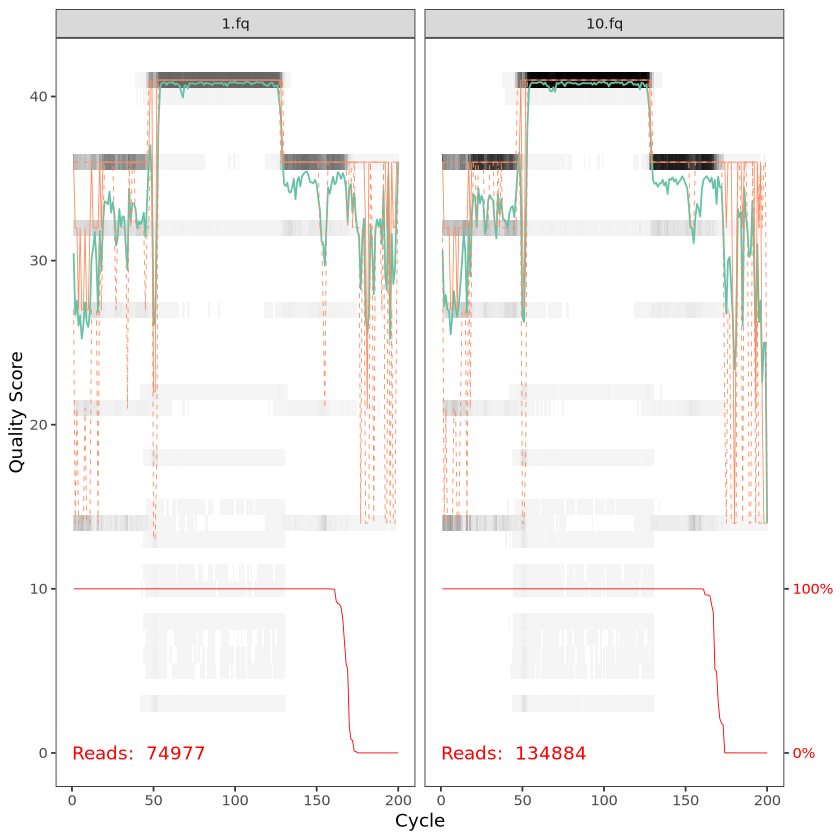

In [245]:
plotQualityProfile(fnFs[1:2])

In [246]:
filtFs <- file.path(path, "filtered", paste0(sample.names, "_F_filt.fastq.gz"))
names(filtFs) <- sample.names

In [250]:
out <- filterAndTrim(fnFs, filtFs,
              maxN=0, maxEE=c(2), rm.phix=TRUE,
              compress=TRUE, multithread=20)
head(out)

R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call


Some input samples had no reads pass the filter.



,reads.in,reads.out
1.fq,74977,73190
10.fq,134884,131617
100.fq,210057,204797
100.fq.gz,210057,204797
101.fq,156199,152422
102.fq,58903,57611


In [251]:
filtFs <- filtFs[file.exists(filtFs)]

In [252]:
errF <- learnErrors(filtFs, multithread=20)

103376355 total bases in 614401 reads from 4 samples will be used for learning the error rates.


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


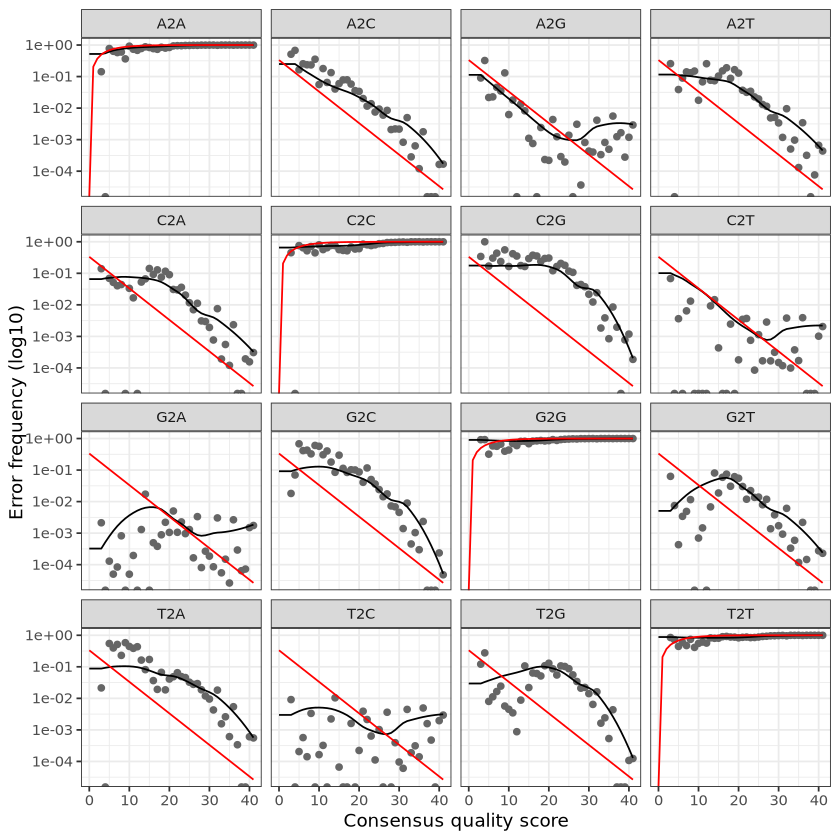

In [253]:
plotErrors(errF, nominalQ=TRUE)

In [254]:
errFbinadj <- learnErrors(filtFs, multithread=20, verbose = TRUE,
                          errorEstimationFunction = loessErrfun_mod4)

103376355 total bases in 614401 reads from 4 samples will be used for learning the error rates.
Initializing error rates to maximum possible estimate.
selfConsist step 1 ....
   selfConsist step 2
   selfConsist step 3
   selfConsist step 4
   selfConsist step 5
   selfConsist step 6
   selfConsist step 7
Convergence after  7  rounds.


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


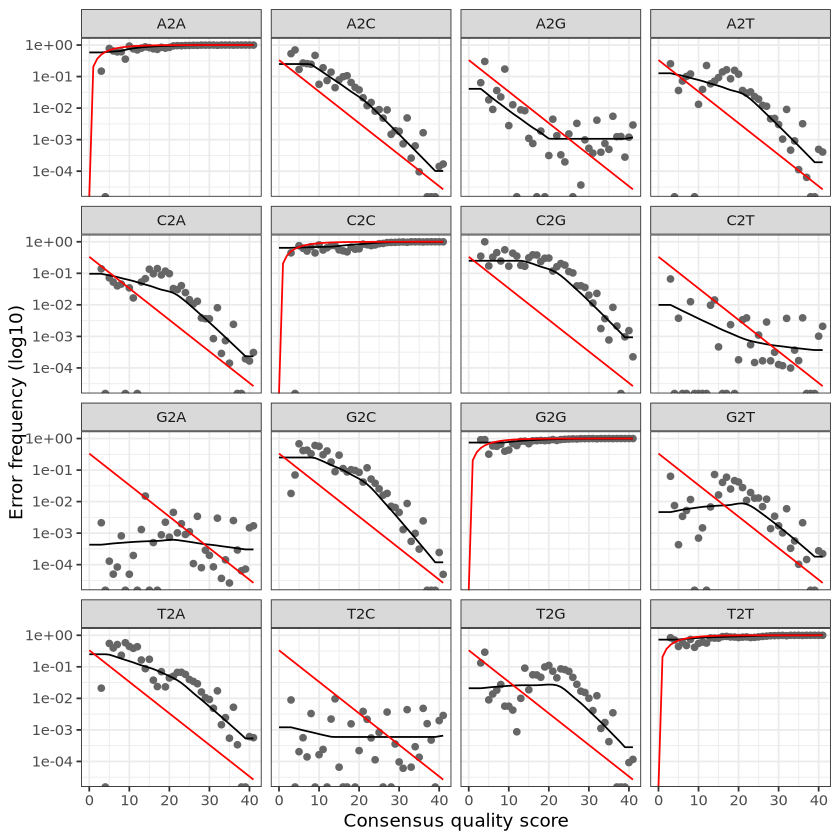

In [255]:
plotErrors(errFbinadj, nominalQ=TRUE)

In [256]:
dadaFs <- dada(filtFs, err=errFbinadj, multithread=20)

Sample 1 - 73190 reads in 52449 unique sequences.
Sample 2 - 131617 reads in 85873 unique sequences.
Sample 3 - 204797 reads in 138550 unique sequences.
Sample 4 - 204797 reads in 138550 unique sequences.
Sample 5 - 152422 reads in 89812 unique sequences.
Sample 6 - 57611 reads in 44506 unique sequences.
Sample 7 - 154924 reads in 103337 unique sequences.
Sample 8 - 37 reads in 37 unique sequences.
Sample 9 - 150063 reads in 82277 unique sequences.
Sample 10 - 17 reads in 17 unique sequences.
Sample 11 - 205955 reads in 107311 unique sequences.
Sample 12 - 53844 reads in 32067 unique sequences.
Sample 13 - 203247 reads in 98986 unique sequences.
Sample 14 - 129193 reads in 91322 unique sequences.
Sample 15 - 184455 reads in 79017 unique sequences.
Sample 16 - 222488 reads in 106269 unique sequences.
Sample 17 - 184862 reads in 84843 unique sequences.
Sample 18 - 216911 reads in 107739 unique sequences.
Sample 19 - 113400 reads in 63929 unique sequences.
Sample 20 - 261954 reads in 1228

In [257]:
seqtab <- makeSequenceTable(dadaFs)
dim(seqtab)

[1]  390 5342

In [258]:
seqtab.nochim <- removeBimeraDenovo(seqtab, method="consensus", 
                                    multithread=20, verbose=TRUE)
dim(seqtab.nochim)

Identified 1686 bimeras out of 5342 input sequences.



[1]  390 3656

In [259]:
sum(seqtab.nochim)/sum(seqtab)

[1] 0.9312526

In [260]:
table(nchar(getSequences(seqtab.nochim)))


153 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 179 181 
  2   4  24  24  13  67  77 157 470 357 368 271 118 521 320 200 160 447  33   7 
182 187 190 
 14   1   1 

In [261]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, getN), rowSums(seqtab.nochim))
# If processing a single sample, remove the sapply calls: e.g. replace sapply(dadaFs, getN) with getN(dadaFs)
colnames(track) <- c("input", "filtered", "denoisedF", "denoisedR", "merged", "nonchim")
rownames(track) <- sample.names
head(track)

Warning message in cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, :
“number of rows of result is not a multiple of vector length (arg 2)”


,input,filtered,denoisedF,denoisedR,merged,nonchim
1.fq,74977,73190,72850,93445,88225,69153
10.fq,134884,131617,131199,156488,152486,124008
100.fq,210057,204797,204272,235115,226964,199519
100.fq.gz,210057,204797,204272,188100,165936,199519
101.fq,156199,152422,152025,68783,66952,137418
102.fq,58903,57611,57363,188968,183028,52436


In [1]:
load(file='../dada2_new_error_model_merged_101924.RData')

In [262]:
save.image(file='../dada2_new_error_model_merged_101924.RData')

In [ ]:
!head ../data_tr

In [263]:
write.csv(track, "../data_tracking_dada2_merged.csv")

In [264]:
collapse = collapseNoMismatch(seqtab.nochim)

In [265]:
tableexport = t(collapse)

In [266]:
tableexport = as.data.frame(tableexport)

In [267]:
tableexport = tableexport[rowSums(tableexport) > 10, ]

In [268]:
tableexport$CountsAcross = rowSums(tableexport)

In [269]:
tableexport <- cbind(ASV = rownames(tableexport), tableexport)
rownames(tableexport) <- 1:nrow(tableexport)

In [270]:
write.csv(tableexport, "../dada2_asv_table_merged.csv")

In [271]:
tableexport

,ASV,1.fq,10.fq,100.fq,100.fq.gz,101.fq,102.fq,103.fq,104.fq,105.fq,⋯,93.fq,94.fq,95.fq,96.fq,97.fq,98.fq,99.fq,PB1.fq,PB2.fq,CountsAcross
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,CACATCGGTTATACGAGAGGCTCAAGTTGATAAACCCCGGCGTAAAGAGTGGTTAAGGAAGATTAAAAACTAAAGCCGAATGCTTTCAAAGCTGTTATACGCTTCCGAGAGTAAGAAGATCAACTACGAAAGTGACTTTATAGCCCCTGACCCCACGAAAGCTATGG,852,8974,5370,5370,0,1254,4104,0,8081,⋯,0,6241,9028,5888,0,0,4571,0,0,1335370
2,CTCAGAGCTTATACGAGAGGCCCTAGTTGATAAACACGGCGTAAAGGGTGGTTAAGGGAGTACATAAATAAAGCCGAAGGGCCCTCTGGCCGTTATACGCTTCTAGGCGCCCGAAGCCCAAACACGAAAGTAGCTTTAATTTAGCCCACCTGACCCCACGAAAACTGAGAAA,0,0,5125,5125,0,0,2229,0,0,⋯,6210,4486,4543,0,2147,1288,0,0,0,1122767
3,CACAGAGCTTATACGAGAGGCTCAAGTTGATAAACCCCGGCGTAAAGAGTGGTTAAGGAAGATTAAAAACTAAAGCCGAATGCTTTCAAAGCTGTTATACGCTTCCGAGAGTAAGAAGATCAACTACGAAAGTGACTTTATAGCCCCTGACCCCACGAAAGCTATGG,629,4239,1776,1776,0,1417,3399,0,4128,⋯,0,5602,3138,4286,0,0,3336,0,0,1060219
4,CACATCGGTTATACGAGAGGCCCAAGTTGATTGACATCGGCGTAAAGCGTGGTTAAGGCCAAAAATGAAACTAAAGCCGAACACCTTCAGAGCTGTTATACGCATCCGAAGGCAAGAAGTTCAACCACGAAGGTGGCTTTATAACCCCTGAACCCACGAAAGCTAAGATA,1356,0,11474,11474,15392,2506,6661,0,0,⋯,0,15943,8262,13672,14978,3879,3301,0,0,1010723
5,CACATCGGTTATACGAGAGGCCCAAGTTGACAAACCCCGGCGTAAAGAGTGGTTAAGAAAAATTTAAAACTAAAGCCGAATGCCCTCAAAGCTGTTATACGCACCCGAAGGTAAGAAGCCCAATCACGAAAGTGGCTTTACATTTCCCGAACCCACGAAAGCTATGAAA,4688,0,10891,10891,0,1537,2852,0,0,⋯,12969,4128,4000,10607,0,2450,4042,0,0,798996
6,CACATCGGTTAAACGAGAGGCCCTAGTTGATAGTACAACGGCGTAAAGCCTGGTTAAGGGTGAACAAAATAAAGCCGAATGGCCCTTTGGCTGTCATACGCTTCTAGGTGCCTGAAGCCCAACATACGAAAGTCGCTTTAAAGTAGCCTACCTGATCCCACGAAAACTGAGAAA,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,764505
7,CACATCGGTTATACGAGAGGCCCTAGTTGATAAATACCGGCGTAAAGAGTGGTTACGAAAAAATGTTTAATAAAGCCGAACACCCCCTCAGCCGTCATACGCACCTGGAGGCACGAAGACCTACTGCGAAAGCAGCTTTAATTATACCCGAATCCACGACAGCTACGA,0,0,3391,3391,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,747008
8,CACATCGGTTATACGAGAGGCCCTAGTTGATAAACACGGCGTAAAGGGTGGTTAAGGGAGTACATAAATAAAGCCGAAGGGCCCTCTGGCCGTTATACGCTTCTAGGCGCCCGAAGCCCAAACACGAAAGTAGCTTTAATTTAGCCCACCTGACCCCACGAAAACTGAGAAA,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,730478
9,CTCAGAGCTGATACGAGAGGCTCAAGTTGATAAACCCCGGCGTAAAGAGTGGTTAAGGAAGATTAAAAACTAAAGCCGAATGCTTTCAAAGCTGTTATACGCTTCCGAGAGTAAGAAGATCAACTACGAAAGTGACTTTATAGCCCCTGACCCCACGAAAGCTATGG,0,5949,1784,1784,0,0,1873,0,5390,⋯,0,3183,3935,3824,0,0,2840,0,0,730402


In [10]:
loessErrfun_mod4 <- function(trans) {
  qq <- as.numeric(colnames(trans))
  est <- matrix(0, nrow=0, ncol=length(qq))
  for(nti in c("A","C","G","T")) {
    for(ntj in c("A","C","G","T")) {
      if(nti != ntj) {
        errs <- trans[paste0(nti,"2",ntj),]
        tot <- colSums(trans[paste0(nti,"2",c("A","C","G","T")),])
        rlogp <- log10((errs+1)/tot)  # 1 psuedocount for each err, but if tot=0 will give NA
        rlogp[is.infinite(rlogp)] <- NA
        df <- data.frame(q=qq, errs=errs, tot=tot, rlogp=rlogp)
        
        # original
        # ###! mod.lo <- loess(rlogp ~ q, df, weights=errs) ###!
        # mod.lo <- loess(rlogp ~ q, df, weights=tot) ###!
        # #        mod.lo <- loess(rlogp ~ q, df)
        
        # jonalim's solution
        # https://github.com/benjjneb/dada2/issues/938
        mod.lo <- loess(rlogp ~ q, df, weights = log10(tot),degree = 1, span = 0.95)
        
        pred <- predict(mod.lo, qq)
        maxrli <- max(which(!is.na(pred)))
        minrli <- min(which(!is.na(pred)))
        pred[seq_along(pred)>maxrli] <- pred[[maxrli]]
        pred[seq_along(pred)<minrli] <- pred[[minrli]]
        est <- rbind(est, 10^pred)
      } # if(nti != ntj)
    } # for(ntj in c("A","C","G","T"))
  } # for(nti in c("A","C","G","T"))
  
  # HACKY
  MAX_ERROR_RATE <- 0.25
  MIN_ERROR_RATE <- 1e-7
  est[est>MAX_ERROR_RATE] <- MAX_ERROR_RATE
  est[est<MIN_ERROR_RATE] <- MIN_ERROR_RATE
  
  # enforce monotonicity
  # https://github.com/benjjneb/dada2/issues/791
  estorig <- est
  est <- est %>%
    data.frame() %>%
    mutate_all(funs(case_when(. < X40 ~ X40,
                              . >= X40 ~ .))) %>% as.matrix()
  rownames(est) <- rownames(estorig)
  colnames(est) <- colnames(estorig)
  
  # Expand the err matrix with the self-transition probs
  err <- rbind(1-colSums(est[1:3,]), est[1:3,],
               est[4,], 1-colSums(est[4:6,]), est[5:6,],
               est[7:8,], 1-colSums(est[7:9,]), est[9,],
               est[10:12,], 1-colSums(est[10:12,]))
  rownames(err) <- paste0(rep(c("A","C","G","T"), each=4), "2", c("A","C","G","T"))
  colnames(err) <- colnames(trans)
  # Return
  return(err)
}